# Fitting global HDX-MS folding kinetics from Lorentzian curve fitting

Using the population fractions of the unfolded, intermediate and folded state from Lorentzian curve fitting, the refolding kinetics were fitted using the ODE model (k1, k-1 and k2).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sympy import Eq
from symfit import Variable, Parameter, D, Fit, ODEModel, exp
from symfit.core.minimizers import *
from symfit.core.objectives import LeastSquares
from smitting.fitting import ODEFit
import os

In [2]:
directory = '.'

In [3]:
time = np.array([60*60, 30*60, 20*60, 15*60, 10*60, 5*60, 1*60, 40, 20, 0])[::-1]
states = ['FD', 'native', 'i1']

In [4]:
files = [f for f  in os.listdir(directory) if 'curve' in f]
files

['global_PpiB_4C_Fitting_curve', 'Lorentzian_curve_fitting_PpiB WT.ipynb']

In [6]:
# We choose the first file to start with:
data_arr = np.genfromtxt(os.path.join(directory, files[0]))[:, ::-1]
data_arr.shape

(3, 10)

<IPython.core.display.Javascript object>


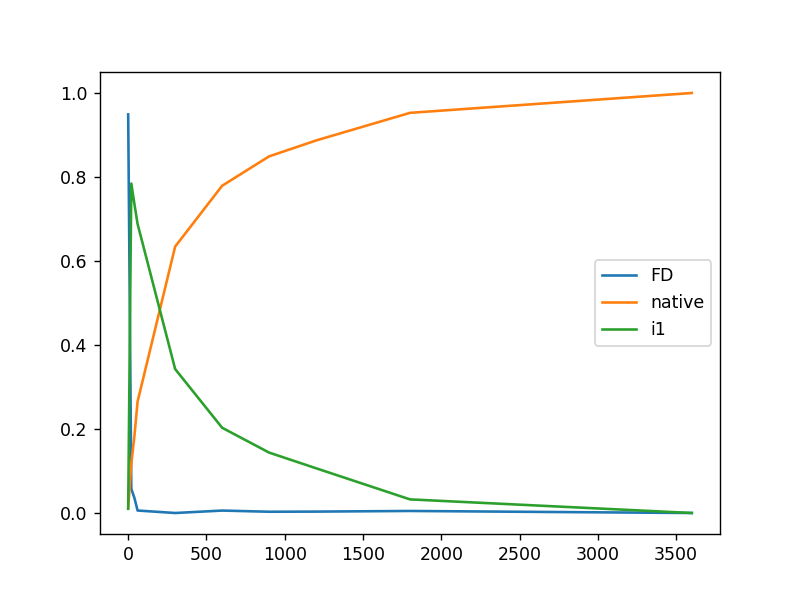

In [9]:
# Plotting the imported data:
plt.figure()
for d, s in zip(data_arr, states):
    plt.plot(time, d, label=s)
_ = plt.legend()

## ODE model fitting U <-> I -> F

In [10]:
# First we create a dictionary with the names of the states and their data
data = {
    'FD': data_arr[0],
    'Native': data_arr[1], 
    'int1': data_arr[2],
}

# Then another dictionary which defines the inital conditions. 
# At t=0, the concentration of FD is set to one, other to zero
initial = {'t': 0, 'FD': 1, 'int1':0, 'Native': 0}

# We define the model with a string like this
# This model has an equillibrium between FD and int1 with an irreversible reaction from int1 to the Native
s = 'FD <-> int1 -> Native'

# The fit object is initialized by giving it the timepoints and the data dictionary
fit = ODEFit(time, **data)

# Then we can make the model
fit.make_model(s, initial)
print(fit.model)

Derivative(FD, t; k_FDint1, k_int1FD, k_int1Native) = -10**k_FDint1*FD + 10**k_int1FD*int1
Derivative(Native, t; k_FDint1, k_int1FD, k_int1Native) = 10**k_int1Native*int1
Derivative(int1, t; k_FDint1, k_int1FD, k_int1Native) = 10**k_FDint1*FD - 10**k_int1FD*int1 - 10**k_int1Native*int1


In [11]:
# To print the model:
for item in fit.model.model_dict.items():
    display(Eq(item[0], item[1]))

Eq(Derivative(FD, t), -10**k_FDint1*FD + 10**k_int1FD*int1)

Eq(Derivative(Native, t), 10**k_int1Native*int1)

Eq(Derivative(int1, t), 10**k_FDint1*FD - 10**k_int1FD*int1 - 10**k_int1Native*int1)

Note that in this model the k-rates are input only as the exponent with base 10. This is because the k-values usually span multiple orders of magnitude and fitting algoritms typically take linear steps instead of logarithmic. This means that if the parameter returned from the fititng is $-2$, the actual value is $10^{\text{-}2}$

In [12]:
# We set all parameters bounds and initial guesses:
for k in fit.parameters:
    fit.set_par(k, value=-2, min=-3.5, max=1)
    
# To set an individual parameter (ie k value of reaction of intermediate 1 to FD:
fit.set_par('k_int1FD', value=-3, min=-2, max=0)

<IPython.core.display.Javascript object>


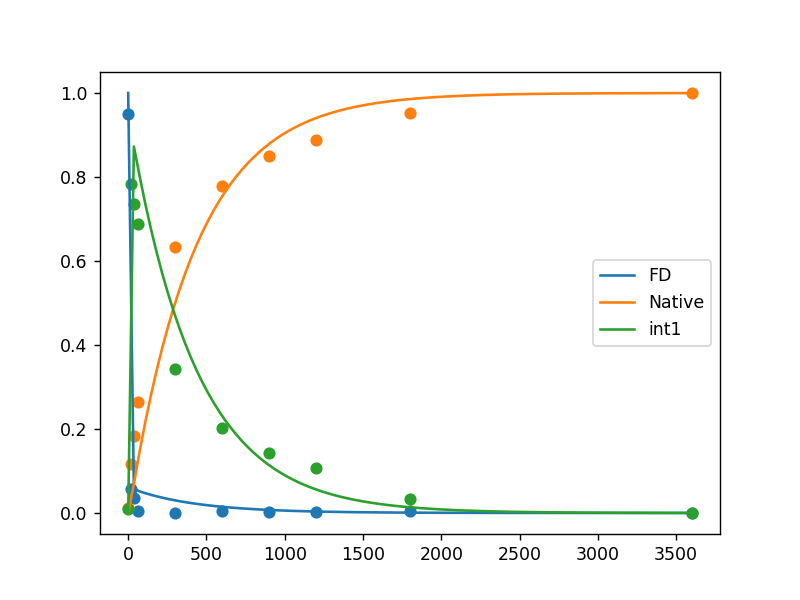

interactive(children=(FloatSlider(value=-2.0, description='k_int1FD', max=0.0, min=-2.0, step=0.02), FloatSlid…

In [14]:
# We can use fit.interactive for checking and adjusting initial guesses
fit.interactive()

In [15]:
{k: v.value for k, v in fit.parameters.items()}

{'k_int1FD': -2.0, 'k_FDint1': -0.8, 'k_int1Native': -2.6}

In [16]:
# We make the fit object, using the minimizer DifferentialEvolution. This minimzer searches all parameter 
# space for a global minimum. We then use SLSQP in a second step to refine the result. I've not tested all
# possibilities exhaustively so there might be better solutions
fit.make_fit(minimizer=[DifferentialEvolution, SLSQP])

In [17]:
fit.execute()

In [18]:
print(fit.res)

Scalar Parameters:
Parameter | Value       | Standard Deviation
k_FDint1    8.272749e-01  2.499993e-01
k_int1FD    -1.290588e-01  6.667881e-02
k_int1Native-2.484892e+00  6.448847e-02
Status message         Optimization terminated successfully.
Number of iterations   26
Objective              <symfit.core.objectives.LeastSquares object at 0x00000249DE3BBCC0>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.DifferentialEvolution object at 0x00000249DE3C85C0>, <symfit.core.minimizers.SLSQP object at 0x00000249DE3C8A90>])

Goodness of fit qualifiers:
chi_squared            0.08454399225070694
objective_value        0.04227199612535347
r_squared              0.9718186821282423


In [19]:
for k, v in fit.res.params.items():
    print(k, v, 10**v)

k_FDint1 0.8272749104204046 6.718540050499896
k_int1FD -0.1290587922137221 0.7429185591763043
k_int1Native -2.4848921424526376 0.0032742200042265627


The found k value for conversion from `FD` to `int1` is $10^{0.83}$ which is equal to 6.72 $s^{-1}$. This is the largest value in the kinetic scheme which is as expected because the intermediate is formed very fast.

<IPython.core.display.Javascript object>


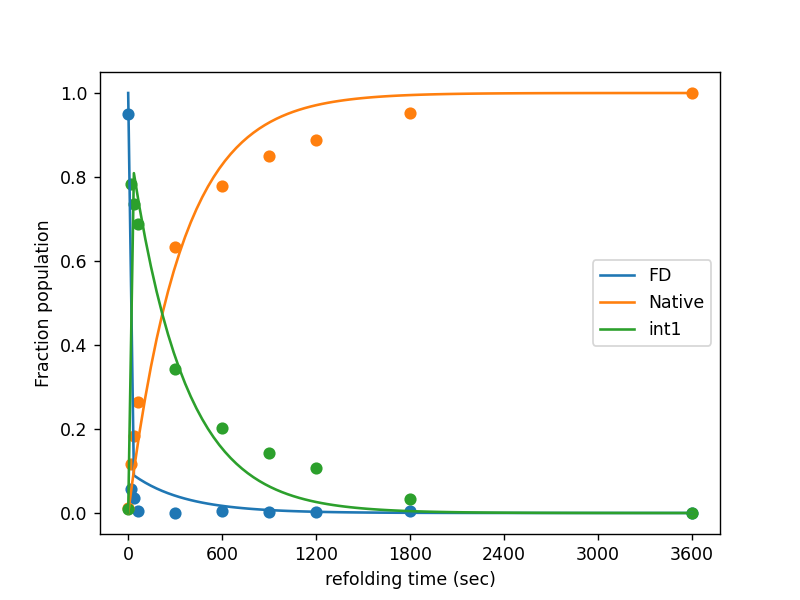

In [21]:
#Plotting the ODE model on the data points
fig, ax = fit.plot_result()
ax.set_xlabel('refolding time (sec)')
ax.set_ylabel('Fraction population')
ax.set_xticks((0,600,1200,1800,2400,3000,3600))
